# Modeling Planetary Motion of 1 and 2 Star Systems
## 1 Star System
We first define a vector for the state of the planet with 1 star.

$$P = \begin{bmatrix}
x\\
y\\
v_x\\
v_y
\end{bmatrix}
$$

The potision and instantaneous velocity are the variables of importance, given constant mass. The position is measured from the origin where we place the star. We want to know where the planet is going so we need the time derivative of the state vector.  
$$ \ \ \ \
\frac{dP}{dt} = \begin{bmatrix}
\frac{dx}{dt}\\
\frac{dy}{dt}\\
\frac{dv_x}{dt}\\
\frac{dv_y}{dt}
\end{bmatrix} = f(p,t) = 
\begin{bmatrix}
v_x\\
v_y\\
-\frac{GMx}{\sqrt{x^2 + y^2}^3}\\
-\frac{GMy}{\sqrt{x^2 + y^2}^3}
\end{bmatrix}$$

Now we are going to use the fourth order Runge Kutta method to find the path of the planet. Given an initial state this method can find the path the planet takes.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
%matplotlib inline 
from matplotlib import animation as ani
def truncate(f, n):
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])
def dP_dt(P,t):
    G = 1
    M = .5
    x, y,vx,vy = P
    r3 = np.hypot(x,y)**3
    ax = -G*M*x/r3
    ay = -G*M*y/r3
    return np.array((vx,vy,ax,ay))
def rk4_path(tmax, h, P0):
    steps = int(tmax/h)
    path = np.empty((steps+1, 4))
    P = np.copy(P0)
    path[0] = P
    for i in range(steps):
        F1 = h*dP_dt(P, i*h)
        F2 = h*dP_dt(P + F1/2, (i+0.5)*h)
        F3 = h*dP_dt(P + F2/2, (i+0.5)*h)
        F4 = h*dP_dt(P + F3, (i+1)*h)
        P += (F1 + 2*F2 + 2*F3 + F4)/6.
        path[i+1] = P
    return path

Now we can choose an initial state of the planet and print out the data of its trajectory

In [2]:
P0 = np.array([1.,0.,0.,1.])
print('   x','         ','y','         ', 'vx','        ','vy')
print(rk4_path(1,.1,P0))

   x           y           vx          vy
[[ 1.          0.          0.          1.        ]
 [ 0.99750416  0.09991682 -0.04983411  0.99751036]
 [ 0.99006591  0.19933981 -0.09868966  0.99016359]
 [ 0.97782894  0.29779901 -0.14567005  0.97830976]
 [ 0.9610196   0.3948691  -0.19002746  0.96248195]
 [ 0.93992975  0.49018461 -0.23120411  0.94333357]
 [ 0.91489689  0.58344866 -0.2688451   0.92157125]
 [ 0.88628428  0.67443511 -0.30278635  0.89789502]
 [ 0.85446319  0.76298556 -0.33302568  0.872953  ]
 [ 0.81979856  0.84900255 -0.35968581  0.8473128 ]
 [ 0.78263841  0.93244076 -0.38297648  0.82144844]]


This is cool to see that it worked, but what exactly is it saying? For that we are going to plot the data so we can actually see whats going on.

In [3]:
def plot_rk4(tmax, h, P0, standalone=True):
    path = rk4_path(tmax, h, P0)
    plt.plot(path[:,0], path[:,1])
    plt.axis('equal')
    plt.plot(0, 0, 'yo', ms=5)

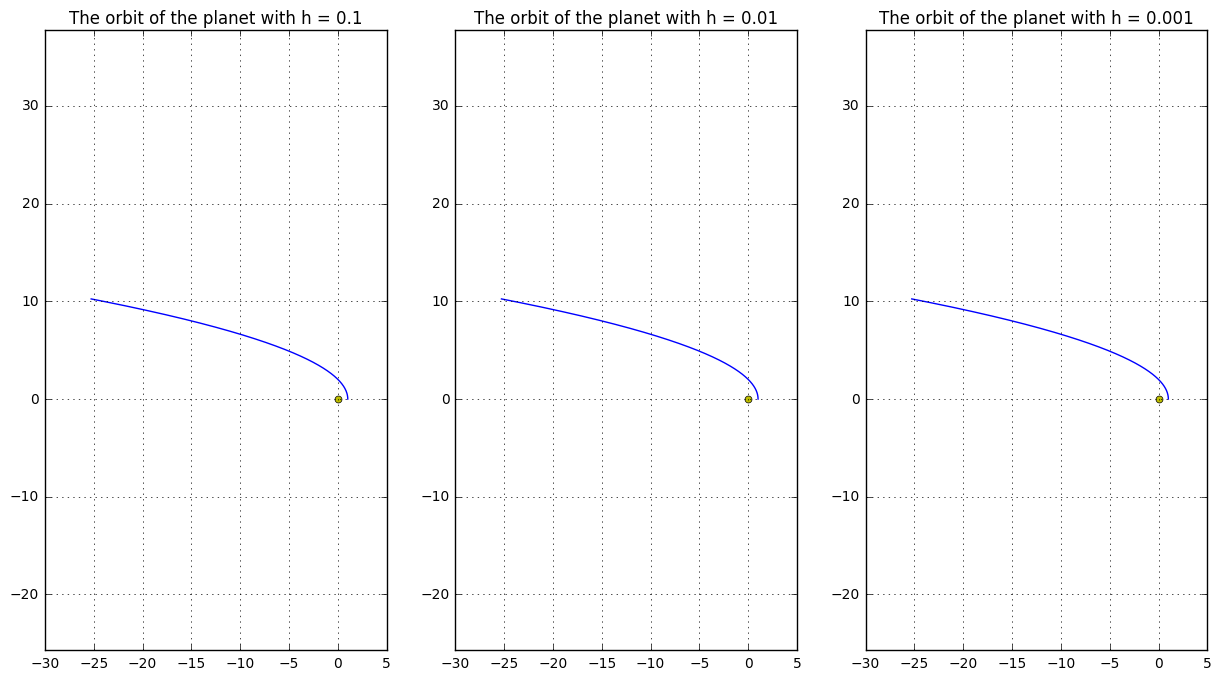

In [4]:
plt.figure(figsize = (15,8))
P0 = np.array([1.,0.,0.,1.])
for i,h in enumerate([.1,.01,.001]):
    plt.subplot(1,3,i + 1)
    plot_rk4(100,h,P0)
    plt.title('The orbit of the planet with h = {}'.format(h))
    plt.grid()

Running this method with the initial conditions we have, show a trajectory of the planet escaping the presence of the sun which isn't how planets orbit so we'll make an adjustment to the initial conditions.

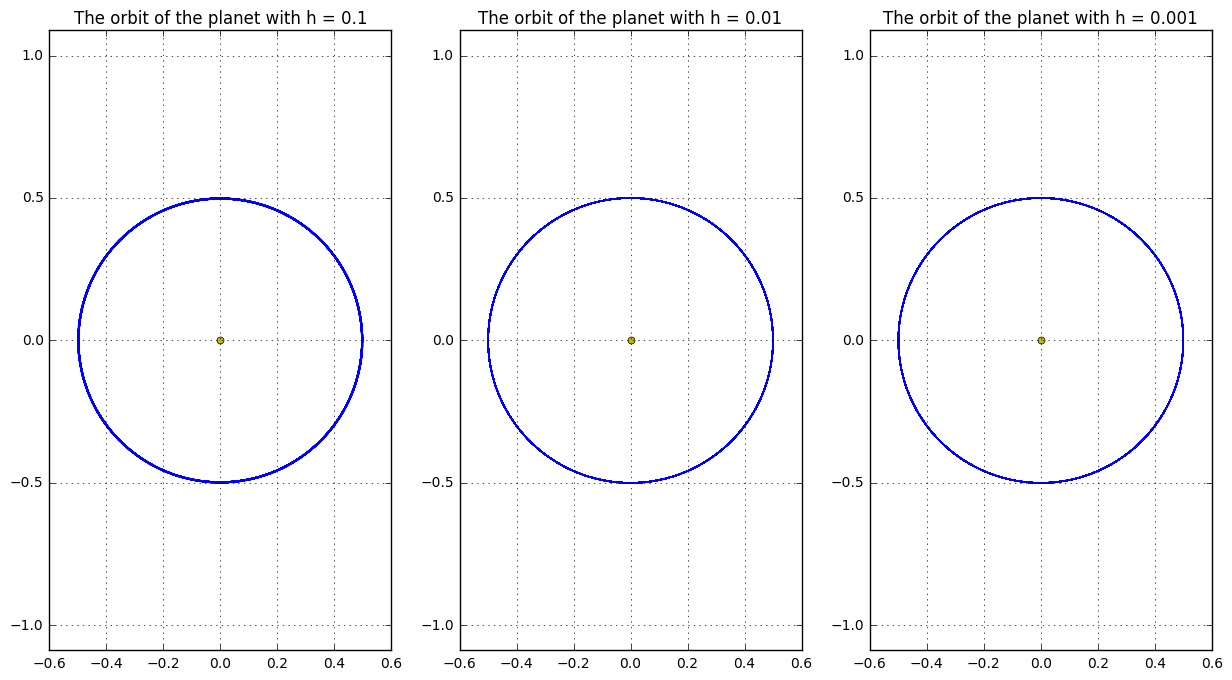

In [5]:
plt.figure(figsize = (15,8))
P0 = np.array([.5,0.,0.,1.])
for i,h in enumerate([.1,.01,.001]):
    plt.subplot(1,3,i + 1)
    plot_rk4(100,h,P0)
    plt.title('The orbit of the planet with h = {}'.format(h))
    plt.grid()

We want to find the different types of orbits that we can have, so I'll create a loop that defines a bunch of different initial conditions and then well run it through the algorithm. As for the step size, we need something small enough to where we get the 'right' movement of the planet, but the smaller the step size the longer it takes. After some trial and error, $h = .001$ seems to be the best size to fulfill that requirement 

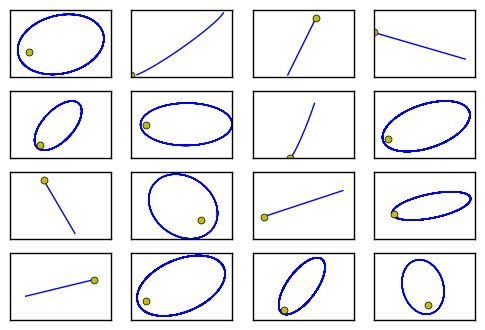

In [6]:
for i in range(16):
    P0 =  np.random.random_sample((4,))
    for j in range(4):
        P0[j] = truncate(P0[j], 4)
    plt.subplot(4,4,i + 1)
    plot_rk4(100,.001,P0)
    #plt.title('{}'.format(P0))
    plt.xticks([])
    plt.yticks([])
    plt.grid()

From this we can see that the shapes that the orbits seem to be are either elliptical, circular or a straight line away from the sun. I was going to try smaller time steps, but it just seems that the orbits don't deviate from the 3 mentioned. Simliar to the straight line is a sort of hyperbolic motion shown here.

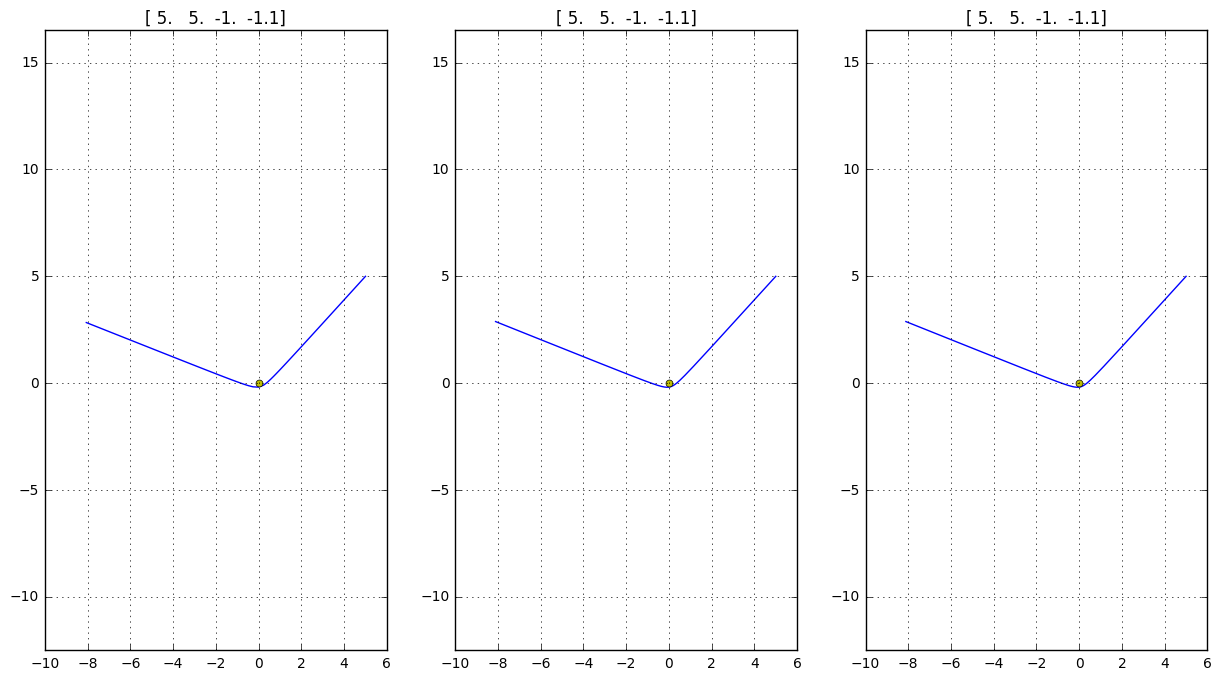

In [7]:
plt.figure(figsize = (15,8))
P0 = np.array([5,5,-1.,-1.1])
for i,h in enumerate([.1,.01,.001]):
    plt.subplot(1,3,i + 1)
    plot_rk4(10,h,P0)
    plt.title('{}'.format(P0))
    plt.grid()

I still classify this as a straight line, but I just wanted to show it. 

## 2 Star System
The two star system is a little more tricky so we need to modify our code slightly. We make the assumption that the two stars are equal distance away from the origin so that they orbit in a circle around the origin. With that in mind we now calculate the acceleration of the planet due to the 2 stars. 

In [8]:
def dP_dt2(P,t):
    G = 1
    M = .5
    R = .5
    x1 = R*np.cos(t)
    x2 = -x1
    y1 = R*np.sin(t)
    y2 = -y1
    x, y,vx,vy = P
    r31 = np.hypot((x - x1),(y - y1))**3
    ax1 = -G*M*(x - x1)/r31
    ay1 = -G*M*(y - y1)/r31
    r32 = np.hypot((x - x2),(y - y2))**3
    ax2 = -G*M*(x - x2)/r32
    ay2 = -G*M*(y - y2)/r32
    ax = ax1 + ax2
    ay = ay1 + ay2
    return np.array((vx,vy,ax,ay))
def rk4_path2(tmax, h, P0):
    steps = int(tmax/h)
    path = np.empty((steps+1, 4))
    P = np.copy(P0)
    path[0] = P
    for i in range(steps):
        F1 = h*dP_dt2(P, i*h)
        F2 = h*dP_dt2(P + F1/2, (i+0.5)*h)
        F3 = h*dP_dt2(P + F2/2, (i+0.5)*h)
        F4 = h*dP_dt2(P + F3, (i+1)*h)
        P += (F1 + 2*F2 + 2*F3 + F4)/6.
        path[i+1] = P
    return path
def plot_rk42(tmax, h, P0, standalone=True):
    path = rk4_path2(tmax, h, P0)
    plt.plot(path[:,0], path[:,1])
    plt.axis('equal')

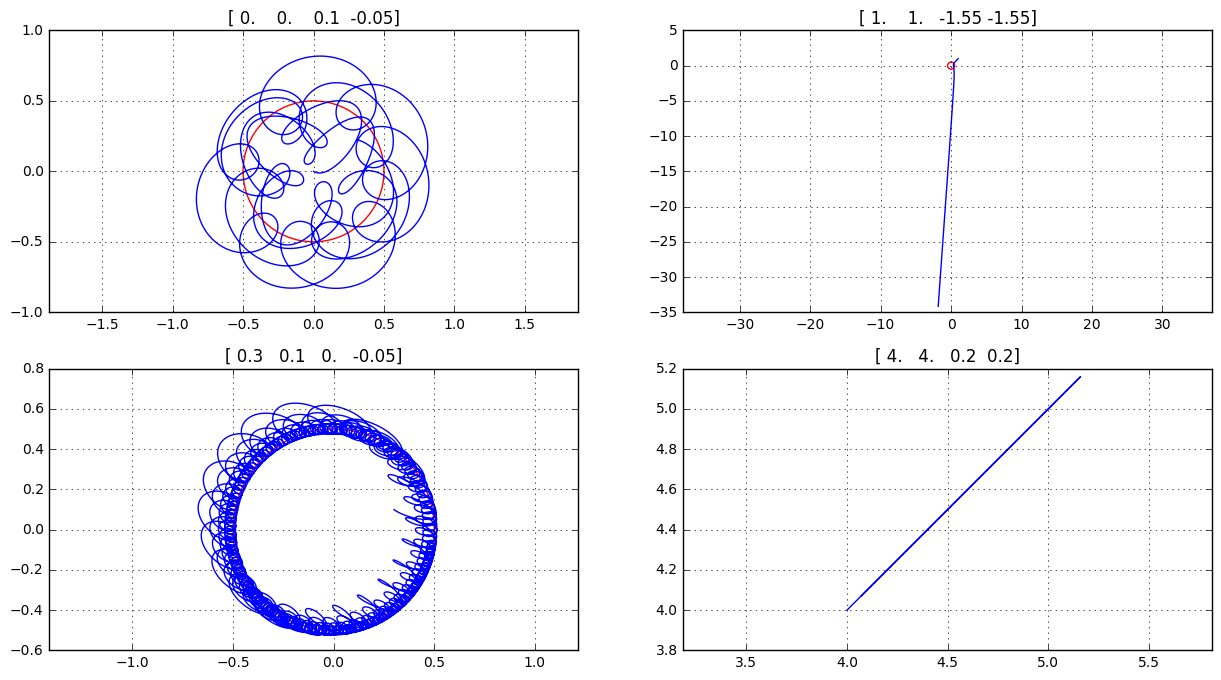

In [9]:
plt.figure(figsize = (15,8))
P0 = np.array([[0.,0.,.1,-.05],[1.,1.,-1.55,-1.55],[0.3,0.1,0.,-.05],[4.,4.,.20,.20]])
for i in range(4):
    ax = plt.subplot(2,2,i + 1)
    plot_rk42(25,.001,P0[i])
    plt.title('{}'.format(P0[i]))
    circle = plt.Circle((0, 0), 0.5, color='r', fill=False)
    ax.add_artist(circle)
    plt.grid()

Just from these 4 initial conditions, we can see that two seem to be 'stable' (not sure if its possible) while the other two shoot off. Let's run this for longer to see if this is truly a stable orbit

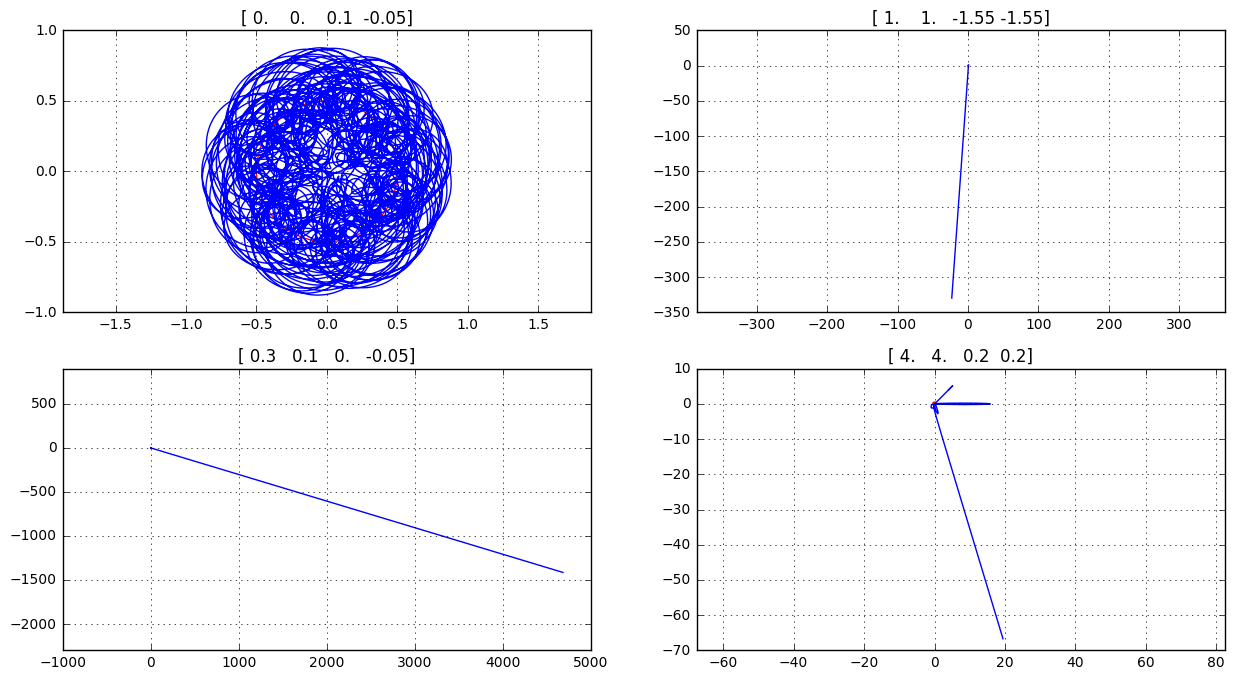

In [10]:
plt.figure(figsize = (15,8))
P0 = np.array([[0.,0.,.1,-.05],[1.,1.,-1.55,-1.55],[0.3,0.1,0.,-.05],[4.,4.,.20,.20]])
for i in range(4):
    ax = plt.subplot(2,2,i + 1)
    plot_rk42(250,.001,P0[i])
    plt.title('{}'.format(P0[i]))
    circle = plt.Circle((0, 0), 0.5, color='r', fill=False)
    ax.add_artist(circle)
    plt.grid()

So the first set of I.C.'s is stable, but lets try some random conditions.

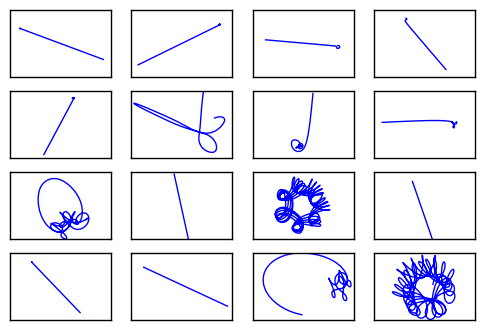

In [11]:
for i in range(16):
    P0 =  np.random.random_sample((4,))
    for j in range(4):
        P0[j] = truncate(P0[j], 4)
    plt.subplot(4,4,i + 1)
    plot_rk42(30,.001,P0)
    #plt.title('{}'.format(P0))
    plt.xticks([])
    plt.yticks([])
    plt.grid()

After doing random conditions, it seems that most orbits just shoot out, which must do with the combined force from the two stars. Some orbits have short lives of stablilty, but then eventually shoot out which I can't figure out why. The planet is picking up velocity as it moves in the system, which overtime reaches escape velocity and then it shoots out. The three types seem to be either crazy motion around the circle that is the orbit of the two stars, also that but then shoot out or just lines that shoot out. After all this tho, a planet being that close to the system isn't really possible so lets move the planet out a bit and see if we can get a real orbit.

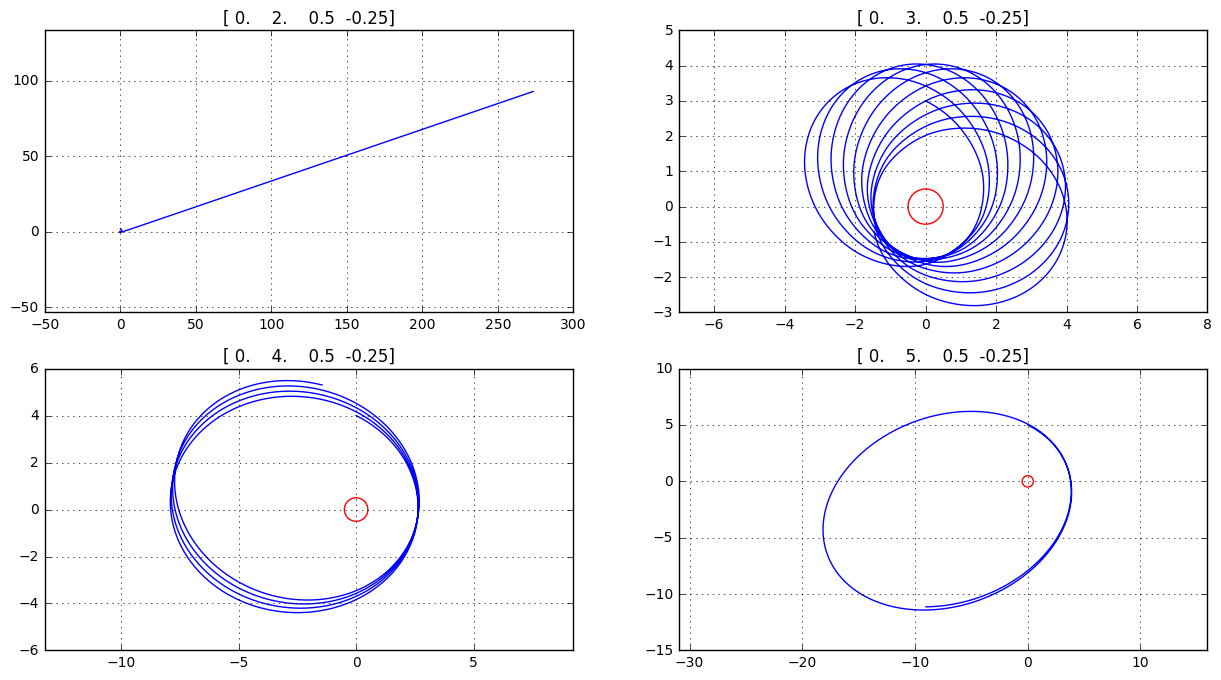

In [12]:
plt.figure(figsize = (15,8))
P0 = np.array([[0.,2.,.5,-.25],[0.,3.,.5,-.25],[0.,4.,.5,-.25],[0.,5.,.5,-.25]])
for i in range(4):
    ax = plt.subplot(2,2,i + 1)
    plot_rk42(300,.001,P0[i])
    plt.title('{}'.format(P0[i]))
    circle = plt.Circle((0, 0), 0.5, color='r', fill=False)
    ax.add_artist(circle)
    plt.grid()

After some research, it was said that we need to treat the 2 star system as effectively a 1 star system. With that in mind we get a stable orbit at an initial position of 4 in the y direction from the origin with initial velocities of .5 and -.25. We can see that its basically a 1 star system. With this in mind we might be able to reproduce the elliptical path.

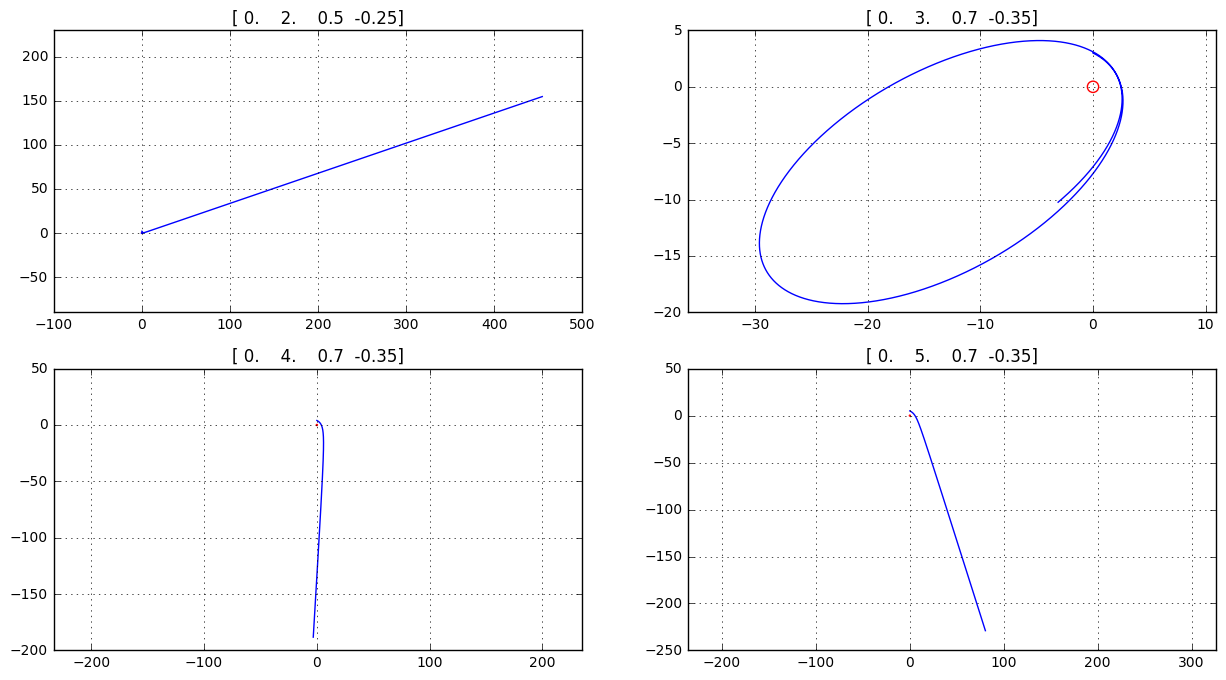

In [13]:
plt.figure(figsize = (15,8))
P0 = np.array([[0.,2.,.5,-.25],[0.,3.,.7,-.35],[0.,4.,.7,-.35],[0.,5.,.7,-.35]])
for i in range(4):
    ax = plt.subplot(2,2,i + 1)
    plot_rk42(500,.001,P0[i])
    plt.title('{}'.format(P0[i]))
    circle = plt.Circle((0, 0), 0.5, color='r', fill=False)
    ax.add_artist(circle)
    plt.grid()

Messing with the initial speed of the planet, I was able to reproduce the elliptical orbit of the 1 star system. Now we can animate the path of the planet and the stars. 